# Gauss Newton Implementation

### It is used to solve non linear least square problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
class GaussNewton:
    def __init__(self,
                 fit_function= callable,
                 max_iter: int = 10000,
                 tolerance_difference: float = 10 ** (-16),
                 tolerance: float = 10 ** (-9),
                 init_guess: np.ndarray = None,
                 ):
        
        self.fit_function = fit_function
        self.max_iter = max_iter
        self.tolerance_difference = tolerance_difference
        self.tolerance = tolerance
        self.coefficients = None
        self.x = None
        self.y = None
        self.init_guess = None
        if init_guess is not None:
            self.init_guess = init_guess
    
    def predict(self, x: np.ndarray):
        return self.fit_function(x, self.coefficients)
        
    def get_residual(self) -> np.ndarray:
        return self.calculate_residual(self.coefficients)
        
    def get_estimate(self) -> np.ndarray:
        return self.fit_function(self.x, self.coefficients)
    
    def calculate_residual(self, coefficients: np.ndarray) -> np.ndarray:
        y_fit = self.fit_function(self.x, coefficients)
        return y_fit - self.y

    def calculate_jacobian(self,x0: np.ndarray,step: float = 10 ** (-7)) -> np.ndarray:
            y0 = self.calculate_residual(x0)

            jacobian = []
            for i, parameter in enumerate(x0):
                x = x0.copy()
                x[i] += step
                y = self.calculate_residual(x)
                derivative = (y - y0) / step
                jacobian.append(derivative)
            jacobian = np.array(jacobian).T

            return jacobian
        
    @staticmethod
    def calculate_pseudoinverse(x: np.ndarray) -> np.ndarray:
        return np.linalg.pinv(x.T @ x) @ x.T
    
    def fit(self,x: np.ndarray,y: np.ndarray,init_guess: np.ndarray = None) -> np.ndarray:
        self.x = x
        self.y = y
        if init_guess is not None:
            self.init_guess = init_guess

        if init_guess is None:
            raise Exception("Initial guess needs to be provided")

        self.coefficients = self.init_guess
        rmse_prev = np.inf
        for k in range(self.max_iter):
            residual = self.calculate_residual(self.coefficients)
            jacobian = self.calculate_jacobian(self.coefficients, step=10 ** (-6))
            self.coefficients = self.coefficients - self.calculate_pseudoinverse(jacobian) @ residual
            rmse = np.sqrt(np.sum(residual ** 2))
                
            if self.tolerance_difference is not None:
                diff = np.abs(rmse_prev - rmse)
                if diff < self.tolerance_difference:
                    return self.coefficients
                if rmse < self.tolerance:
                    return self.coefficients
                rmse_prev = rmse

        return self.coefficients


### Testing the Algorithm on real Dataset

#### Heart Rate as a function of Time (sec) for a twenty-minute period of constant exertion

In [3]:
import pandas as pd
p = pd.read_csv('https://apmonitor.com/che263/uploads/Main/heart_rate.txt')
p

,Time (sec),Heart Rate (BPM)
0,0.0,103
1,5.0,103
2,10.0,103
3,15.0,105
4,20.0,108
...,...,...
236,1180.0,153
237,1185.0,154
238,1190.0,154
239,1195.0,154


In [4]:
COEFFICIENTS = [0.1, 0.1, 0.1]
def func(x, coeff):
    return coeff[0] * x ** 2 + coeff[1] * x  + coeff[2] 


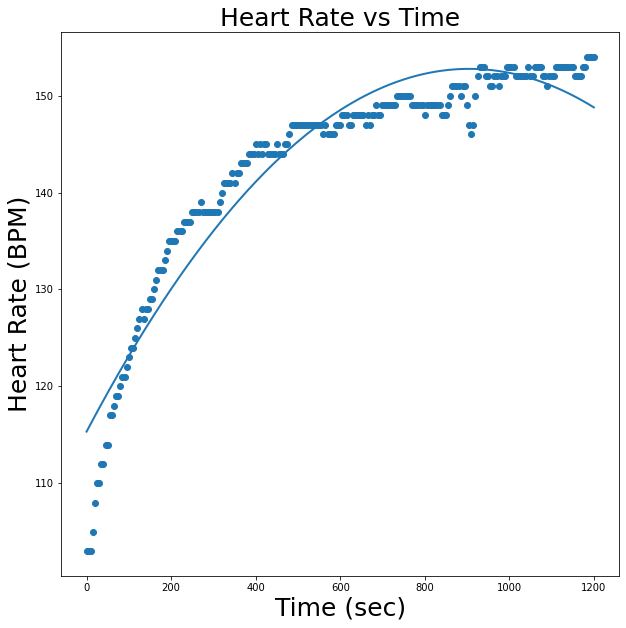

In [5]:
%matplotlib inline

gn = GaussNewton(fit_function=func, max_iter=100, tolerance_difference=10 ** (-6))
init_guess = 100000000 * np.random.random(len(COEFFICIENTS))
_ = gn.fit(p['Time (sec)'], p['Heart Rate (BPM)'], init_guess)
fit = gn.get_estimate()
residual = gn.get_residual()

plt.figure(figsize=(10,10))
plt.xlabel('Time (sec)', size = 25)
plt.ylabel('Heart Rate (BPM)', size = 25)
plt.title('Heart Rate vs Time', size = 25)
plt.scatter(p['Time (sec)'], p['Heart Rate (BPM)'])
plt.plot(p['Time (sec)'], fit, label="Fit", linewidth=2)